In [228]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [229]:
data_NSE = pd.read_csv("NIFTY_50_His_Data_Reversed.csv",parse_dates=["Date"])
data_NYSE = pd.read_csv("NYSE_His_Data.csv",parse_dates=["Date"])

data_NYSE = data_NYSE.rename(columns={"Close":"NYSE_Close"})
data_NSE = data_NSE.rename(columns={"Close":"NSE_Close"})

data_NSE = data_NSE.sort_values("Date")
data_NYSE = data_NYSE.sort_values("Date")

df = pd.merge(data_NSE[["Date","NSE_Close"]],data_NYSE[["Date","NYSE_Close"]],on="Date",how="inner")

C:\Users\kumar\AppData\Local\Temp\ipykernel_22412\1782705472.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data_NSE = pd.read_csv("NIFTY_50_His_Data_Reversed.csv",parse_dates=["Date"])


In [230]:
df["NSE_Return"] = np.log(df["NSE_Close"]/df["NSE_Close"].shift(1))
df["NYSE_Return"] = np.log(df["NYSE_Close"]/df["NYSE_Close"].shift(1))
df.dropna(inplace=True)
df.columns

Index(['Date', 'NSE_Close', 'NYSE_Close', 'NSE_Return', 'NYSE_Return'], dtype='object')

In [231]:
nse_returns = df["NSE_Return"].values

mean_return = np.mean(nse_returns)
std_return = np.std(nse_returns)

np.random.seed(42)
num_steps = len(nse_returns)
initial_price = df["NSE_Close"].iloc[0]

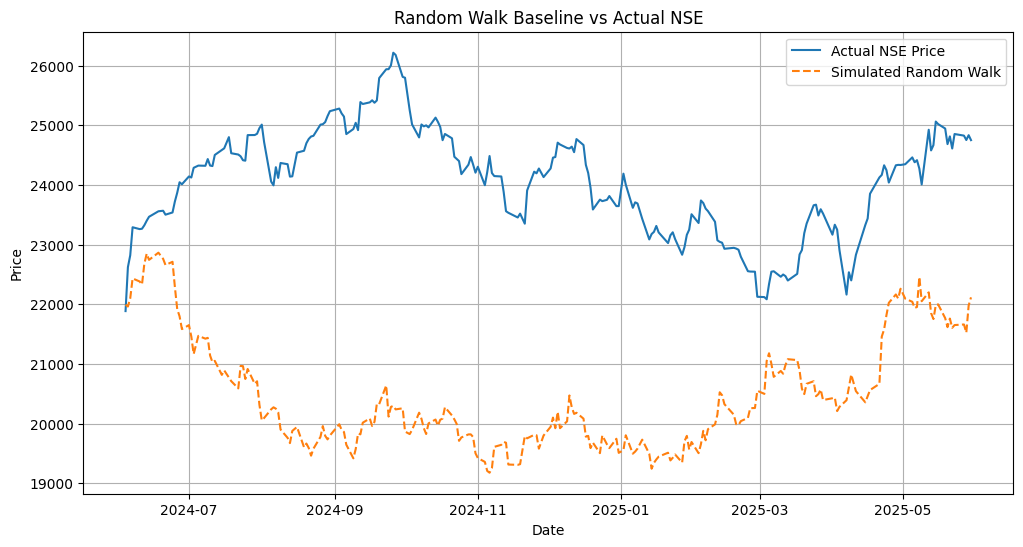

In [232]:
### Single Simulation
rw_noise = np.random.normal(loc=0,scale=std_return,size=num_steps)
rw_simulated_returns = np.cumsum(rw_noise) 
simulated_prices = initial_price * np.exp(rw_simulated_returns)

plt.figure(figsize=(12,6))
plt.plot(df["Date"], df["NSE_Close"].values, label="Actual NSE Price")
plt.plot(df["Date"], simulated_prices, label="Simulated Random Walk", linestyle="--")
plt.title("Random Walk Baseline vs Actual NSE")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

In [233]:
### 10 Simulations
n_sim = 30
sims = []
for _ in range(n_sim):
    noise = np.random.normal(loc=0,scale=std_return,size=num_steps)
    walk = np.cumsum(noise) 
    sim_prices = initial_price * np.exp(walk)
    sims.append(sim_prices)

sims = np.array(sims)
avg_sim = sims.mean(axis=0)
std_sim = sims.std(axis=0)

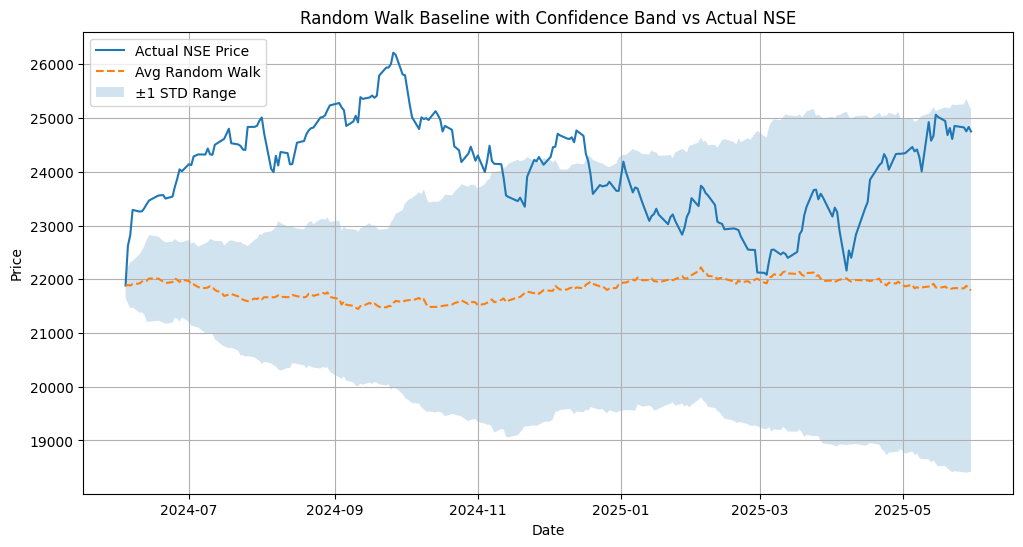

In [234]:
plt.figure(figsize=(12,6))
plt.plot(df["Date"], df["NSE_Close"].values, label="Actual NSE Price")
plt.plot(df["Date"], avg_sim, label="Avg Random Walk", linestyle="--")
plt.fill_between(df["Date"],avg_sim-std_sim,avg_sim+std_sim,alpha=0.2,label="±1 STD Range")
plt.legend()
plt.title("Random Walk Baseline with Confidence Band vs Actual NSE")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

Cumulative Return of Actual NSE VS Random Walk 

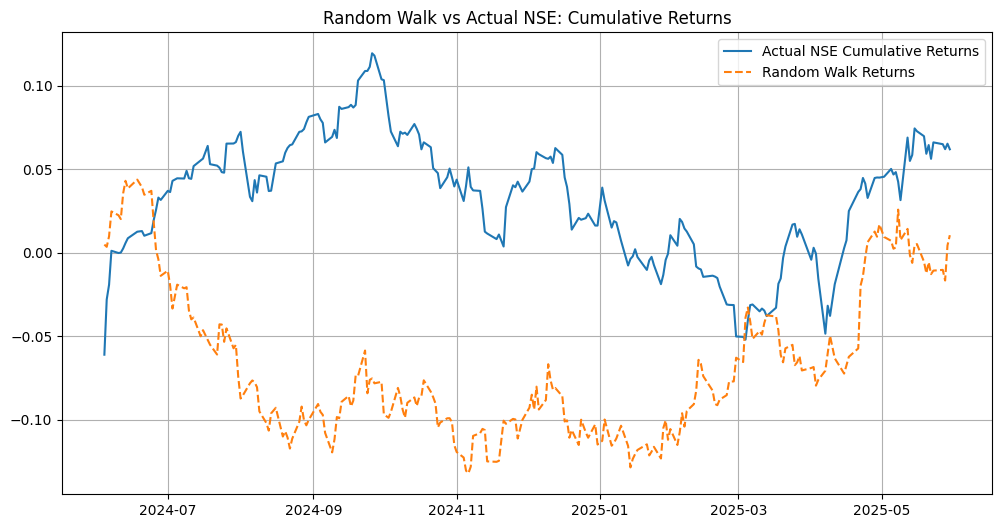

In [235]:
actual_cum_returns = np.cumsum(nse_returns)

plt.figure(figsize=(12,6))
plt.plot(df["Date"], actual_cum_returns, label="Actual NSE Cumulative Returns")
plt.plot(df["Date"], rw_simulated_returns, label="Random Walk Returns", linestyle="--")
plt.legend()
plt.title("Random Walk vs Actual NSE: Cumulative Returns")
plt.grid(True)
plt.show()

Adding Drift to Random Walk

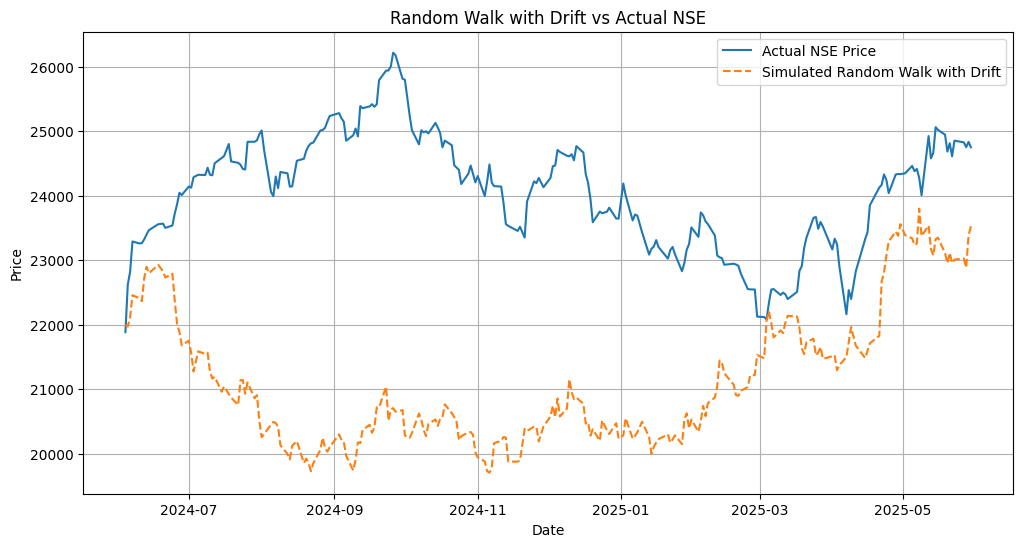

In [236]:
mean_return = df["NSE_Return"].mean()
std_return = df["NSE_Return"].std()
n = len(df)

### Simulating random walk with drift
np.random.seed(42)
rw_noise_drift = np.random.normal(loc = mean_return,scale=std_return,size=n)
rw_drift_return = np.cumsum(rw_noise_drift)
initial_price = df["NSE_Close"].iloc[0]
sim_price_drift = initial_price * np.exp(rw_drift_return)

plt.figure(figsize=(12,6))
plt.plot(df["Date"], df["NSE_Close"].values, label="Actual NSE Price")
plt.plot(df["Date"], sim_price_drift, label="Simulated Random Walk with Drift", linestyle="--")
plt.title("Random Walk with Drift vs Actual NSE")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

Evaluating Error between Actual vs Random Walk

In [237]:
from sklearn.metrics import mean_absolute_error,mean_squared_error

actual_price = df["NSE_Close"].values
mse = mean_squared_error(actual_price,sim_price_drift)
mae = mean_absolute_error(actual_price,sim_price_drift)

print(f"MSE : {mse:.4f}, MAE : {mae:.4f}")


MSE : 10906076.3839, MAE : 2952.5704


Conditional Diffusion Model

In [238]:
import tensorflow as tf
from tensorflow.keras import layers,Model,Input

# Constants
T = 1000
beta_start = 1e-4
beta_end = 0.02
betas = np.linspace(beta_start,beta_end,T)
alphas = 1. - betas
alpha_bars = np.cumprod(alphas)


# Denoising Network ( conditional MLP )
def build_denoiser(input_dim,cond_dim):
    inp = Input(shape=(input_dim+cond_dim+1,))
    x = layers.Dense(256,activation='relu')(inp)
    x = layers.Dense(256,activation='relu')(x)
    x = layers.Dense(128,activation='relu')(x)
    # x = layers.Dropout(0.1)(x)   
    # x = layers.Dense(64, activation='relu')(x)
    out = layers.Dense(input_dim)(x)
    return Model(inp,out)


# Forward Diffusion Func
# def q_sample(x_start, t, noise):
#     alpha_bars_tensor = tf.convert_to_tensor(alpha_bars, dtype=tf.float32)
#     sqrt_alpha_bar_t = tf.gather(tf.sqrt(alpha_bars_tensor), t)
#     sqrt_one_minus_alpha_bar_t = tf.sqrt(1. - tf.gather(alpha_bars_tensor, t))
#     return sqrt_alpha_bar_t[:, None] * x_start + sqrt_one_minus_alpha_bar_t[:, None] * noise

def q_sample(x_start, t, noise):
    alpha_bars_tensor = tf.convert_to_tensor(alpha_bars, dtype=tf.float32)
    alpha_bar_t = tf.gather(alpha_bars_tensor, t)
    # Clip for numerical stability
    alpha_bar_t = tf.clip_by_value(alpha_bar_t, 1e-5, 0.999)
    
    sqrt_alpha_bar_t = tf.sqrt(alpha_bar_t)
    sqrt_one_minus_alpha_bar_t = tf.sqrt(1. - alpha_bar_t)
    
    return sqrt_alpha_bar_t[:, None] * x_start + sqrt_one_minus_alpha_bar_t[:, None] * noise


# Sample Batch 
def get_batch(nse_returns,nyse_returns,batch_size,window_size):
    idx = np.random.randint(window_size,len(nse_returns),batch_size)
    x_start = nse_returns[idx]
    cond = np.array([nyse_returns[i-window_size:i] for i in idx])
    return x_start.reshape(-1,1),cond


# Assemble output and model
{
    "T": T,
    "betas": betas,
    "alpha_bars": alpha_bars,
    "build_denoiser": build_denoiser,
    "q_sample": q_sample,
    "get_batch": get_batch
}

{'T': 1000,
 'betas': array([0.0001    , 0.00011992, 0.00013984, 0.00015976, 0.00017968,
        0.0001996 , 0.00021952, 0.00023944, 0.00025936, 0.00027928,
        0.0002992 , 0.00031912, 0.00033904, 0.00035896, 0.00037888,
        0.0003988 , 0.00041872, 0.00043864, 0.00045856, 0.00047848,
        0.0004984 , 0.00051832, 0.00053824, 0.00055816, 0.00057808,
        0.000598  , 0.00061792, 0.00063784, 0.00065776, 0.00067768,
        0.0006976 , 0.00071752, 0.00073744, 0.00075736, 0.00077728,
        0.0007972 , 0.00081712, 0.00083704, 0.00085696, 0.00087688,
        0.0008968 , 0.00091672, 0.00093664, 0.00095656, 0.00097648,
        0.0009964 , 0.00101632, 0.00103624, 0.00105616, 0.00107608,
        0.001096  , 0.00111592, 0.00113584, 0.00115576, 0.00117568,
        0.0011956 , 0.00121552, 0.00123544, 0.00125536, 0.00127528,
        0.0012952 , 0.00131512, 0.00133504, 0.00135495, 0.00137487,
        0.00139479, 0.00141471, 0.00143463, 0.00145455, 0.00147447,
        0.00149439, 0.00151

Training

In [239]:
model = build_denoiser(input_dim=1,cond_dim=5)
optimizer = tf.keras.optimizers.Adam(1e-4)

# nse_returns = np.array(df["NSE_Return"].values).reshape(-1,1)
# nyse_returns = np.array(df["NYSE_Return"].values)
window_size = 5

scaler_nse = StandardScaler()
scaler_nyse = StandardScaler()

nse_returns_scaled = scaler_nse.fit_transform(df["NSE_Return"].values.reshape(-1, 1))
nyse_returns_scaled = scaler_nyse.fit_transform(df["NYSE_Return"].values.reshape(-1, 1))


for epoch in range(2000):
    idx = np.random.randint(window_size,len(nse_returns_scaled),size=32)
    x_batch = nse_returns_scaled[idx]
    cond_batch = np.array([nyse_returns_scaled[i-window_size:i].flatten() for i in idx])
    t_batch = np.random.randint(1,T,size=32)

    noise = tf.random.normal(shape=x_batch.shape)
    x_noisy = q_sample(tf.convert_to_tensor(x_batch,dtype=tf.float32),
                       tf.convert_to_tensor(t_batch,dtype=tf.int32),
                       noise)

    input_concat = tf.concat([
        x_noisy,
        tf.convert_to_tensor(cond_batch,dtype=tf.float32),
        tf.cast(t_batch[:,None],tf.float32)/T
    ],axis=1)

    with tf.GradientTape() as tape:
        pred_noise = model(input_concat)
        loss = tf.reduce_mean(tf.square(noise-pred_noise))
    
    grads = tape.gradient(loss,model.trainable_weights)
    optimizer.apply_gradients(zip(grads,model.trainable_weights))

    if epoch%100==0:
        print(f"Epoch {epoch}, Loss {loss.numpy():.6f}")

Epoch 0, Loss 0.976071
Epoch 100, Loss 0.302317
Epoch 200, Loss 0.227474
Epoch 300, Loss 0.291977
Epoch 400, Loss 0.309157
Epoch 500, Loss 0.132268
Epoch 600, Loss 0.184173
Epoch 700, Loss 0.075070
Epoch 800, Loss 0.318495
Epoch 900, Loss 0.164769
Epoch 1000, Loss 0.081101
Epoch 1100, Loss 0.475469
Epoch 1200, Loss 0.244782
Epoch 1300, Loss 0.162508
Epoch 1400, Loss 0.197777
Epoch 1500, Loss 0.204120
Epoch 1600, Loss 0.270349
Epoch 1700, Loss 0.251398
Epoch 1800, Loss 0.301694
Epoch 1900, Loss 0.218038


Conditional Sampling

In [240]:
def p_sample(model, x_t, t, nyse_window):
    # Concatenate inputs
    input_concat = tf.concat([
        x_t,
        tf.convert_to_tensor(nyse_window.reshape(1, -1), dtype=tf.float32),
        tf.convert_to_tensor([[t / T]], dtype=tf.float32)
    ], axis=1)
    
    pred_noise = model(input_concat)

    alpha_bar_t = tf.convert_to_tensor(alpha_bars[t], dtype=tf.float32)
    alpha_bar_prev = tf.convert_to_tensor(alpha_bars[t-1] if t > 1 else 1.0, dtype=tf.float32)
    # Add clip to ensure beta_t is positive
    beta_t = tf.clip_by_value(1 - alpha_bar_t / alpha_bar_prev if t > 1 else 1e-5, 1e-5, 0.999)

    # Add small epsilon to prevent division by zero
    coef1 = 1. / tf.sqrt(tf.maximum(alpha_bar_t, 1e-7))
    coef2 = tf.sqrt(tf.maximum(1. - alpha_bar_t, 1e-7))

    mean = coef1 * (x_t - coef2 * pred_noise)

    if t > 1:
        noise = tf.random.normal(shape=x_t.shape)
        sample = mean + tf.sqrt(beta_t) * noise
    else:
        sample = mean

    return sample


def generate_nse_sample(model, nyse_window_scaled, T=200):
    x_t = tf.random.normal((1, 1))  # Start from noise

    for t in reversed(range(1, T)):
        x_t = p_sample(model, x_t, t, nyse_window_scaled)
    
    return x_t.numpy()[0, 0]

i = 100  # Choose any index ≥ window_size
nyse_context = nyse_returns_scaled[i-window_size:i].flatten()

pred_scaled = generate_nse_sample(model, nyse_context)
pred_nse = scaler_nse.inverse_transform([[pred_scaled]])[0, 0]

actual_nse = df["NSE_Return"].iloc[i]

print(f"Predicted NSE Return  : {pred_nse:.4f}")
print(f"Actual NSE Return     : {actual_nse:.4f}")



Predicted NSE Return  : -0.0016
Actual NSE Return     : -0.0056
